In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2

# Load and sample data
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)  # Sample 1% of the data
    return sampled_df

# step 1, load csv files, 
# TODO: to make sure we are loading data from 5 folders, and we need to make sure the images
# have all the 15 classes
train_df = load_and_sample_data('train.csv', 0.5)
val_df = load_and_sample_data('val.csv')
test_df = load_and_sample_data('test.csv')

# Check unique values in label images
# step 1, check the unique values in the label images
def check_unique_values(df):
    unique_values = set()
    for _, row in df.iterrows():
        label = cv2.imread(row['label_path'], cv2.IMREAD_GRAYSCALE)
        unique_values.update(np.unique(label))
    return unique_values

train_unique_values = check_unique_values(train_df)
val_unique_values = check_unique_values(val_df)
test_unique_values = check_unique_values(test_df)

print("Unique values in train labels:", train_unique_values)
print("Unique values in val labels:", val_unique_values)
print("Unique values in test labels:", test_unique_values)

# Update NUM_CLASSES based on unique values
NUM_CLASSES = len(train_unique_values.union(val_unique_values).union(test_unique_values))

# Function to map labels to valid class indices
def map_labels(label, num_classes):
    label_mapped = np.zeros_like(label)
    for i, unique_val in enumerate(np.unique(label)):
        if i < num_classes:
            label_mapped[label == unique_val] = i
        else:
            label_mapped[label == unique_val] = 0  # Map unexpected values to background class
    return label_mapped

# Data generators for training and validation
def data_generator(df, batch_size, img_size, num_classes):
    while True:
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            for _, row in batch_df.iterrows():
                img = cv2.imread(row['im_path'])
                img = cv2.resize(img, (img_size, img_size))
                img = img / 255.0
                
                label = cv2.imread(row['label_path'], cv2.IMREAD_GRAYSCALE)
                label = cv2.resize(label, (img_size, img_size))
                label = map_labels(label, num_classes)
                label = to_categorical(label, num_classes=num_classes)
                
                x_batch.append(img)
                y_batch.append(label)
            yield np.array(x_batch), np.array(y_batch)

# Custom IoU metric
def iou_metric(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Custom Jaccard index
def jaccard_index(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    jaccard = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return jaccard

# U-Net Model
def build_unet_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    
    # Downsampling
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # Upsampling
    u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Parameters
IMG_SIZE = 256  # Resized image size
BATCH_SIZE = 8  # Adjust batch size according to available memory

# Create data generators
train_gen = data_generator(train_df, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)
val_gen = data_generator(val_df, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)

# Build and compile the model
model = build_unet_model(IMG_SIZE, NUM_CLASSES)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_gen, steps_per_epoch=len(train_df) // BATCH_SIZE, epochs=10, validation_data=val_gen, validation_steps=len(val_df) // BATCH_SIZE)

# Evaluate the model
test_gen = data_generator(test_df, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)
model.evaluate(test_gen, steps=len(test_df) // BATCH_SIZE)

# Predict on a sample image
sample_image, sample_mask = next(data_generator(test_df, 1, IMG_SIZE, NUM_CLASSES))
prediction = model.predict(sample_image)[0]




Unique values in train labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
Unique values in val labels: {2, 3, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18}
Unique values in test labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
Epoch 1/10
378/378 [==============================] - 198s 522ms/step - loss: 2.0298 - accuracy: 0.3750 - val_loss: 1.5149 - val_accuracy: 0.5136
Epoch 2/10
378/378 [==============================] - 196s 521ms/step - loss: 1.6688 - accuracy: 0.4655 - val_loss: 1.4012 - val_accuracy: 0.5521
Epoch 3/10
378/378 [==============================] - 197s 521ms/step - loss: 1.5380 - accuracy: 0.5092 - val_loss: 1.3732 - val_accuracy: 0.5710
Epoch 4/10
378/378 [==============================] - 203s 537ms/step - loss: 1.4895 - accuracy: 0.5215 - val_loss: 1.3645 - val_accuracy: 0.5792
Epoch 5/10
378/378 [==============================] - 191s 505ms/step - loss: 1.4601 - accuracy: 0.5285 - val_loss: 1.3651 - val_accuracy: 0.5828
Epoch 

[1.4166265726089478, 0.5624714493751526]

NameError: name 'sample_image' is not defined

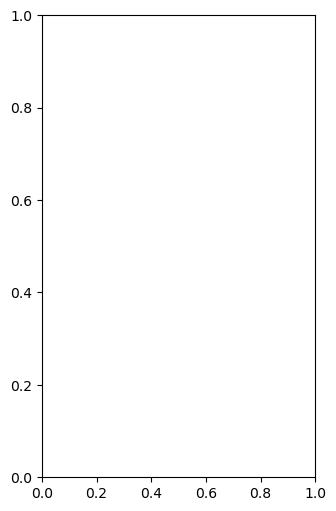

In [1]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image[0])
plt.title('Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(sample_mask[0], axis=-1))
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.argmax(prediction, axis=-1))
plt.title('Predicted Mask')
plt.axis('off')